In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
import PyCO2SYS as pyco2

In [43]:
df = pd.read_csv('full.csv')

In [3]:
def hist(df):
    plt.hist(df['TOTAL'], 20)
    plt.title('Distribution of estimated biomass')
    plt.xlabel('Estimated biomass')
    plt.ylabel('Entries')

In [4]:
def split_data(df):
    y = df.iloc[:, df.columns == 'TOTAL']
    X = df.iloc[:, df.columns != 'TOTAL']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
        test_size=0.5, random_state=123) 
    

    return X_train, X_val, y_train, y_val, X_test, y_test

def fit_forest(X_train, y_train):
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train.values.ravel())
    return forest

In [5]:
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def predict_and_score(X_val, y_val, forest):
    forest_pred = forest.predict(X_val)
    print('MAE score: ', mean_absolute_error(y_val, forest_pred))
    print('R2 score: ', r2_score(y_val, forest_pred))
    print('Smape score: ', smape(y_val, forest_pred.reshape(len(X_val),1)))
    return forest_pred

## Functions for preprocessing
### Replacing values with median for measures taken under freshwater rinses
### Calculating Dissolved Inorganic Carbon

In [ ]:
# Replace values recorded during freshwater rinses with median
def replace_freshwater(df):
    df = df.reset_index(drop=True)

    # Get indices where salinity < 30
    result = np.where(df['FerryBox.SBE45_Salinity']<=30)
    idxs = result[0]
    
    # Ferrybox sensors that would be affected by the rinse
    sensors = ['FerryBox.C3_CDOMFluorescence', 'FerryBox.C3_Temperature', 'FerryBox.C3_CHLAFluorescence',
               'FerryBox.C3_Turbidity','FerryBox.Optode_Saturation', 'FerryBox.SBE45_Salinity']

    # Replace with median for column
    for s in sensors:   
        df.loc[idxs, s] = df[s].median()
    
    # Fill missing values with median for column
    df = df.fillna(df.median())
    
    return df

def prep_dataset(df):
    df1 = replace_freshwater(df)
    df2 = get_dic(df1)
    df2 = df2.drop(columns=['FCO2'])
    return df2
   
def get_dic(df):
    for index, row in df.iterrows():
        alk = calc_alk(row['LATITUDE'], row['FerryBox.C3_Temperature'],row['FerryBox.SBE45_Salinity'])
        dic = calc_dic(alk, row['FCO2'])      
        df.at[index,'DIC'] = dic
    return df

def calc_alk(LAT, SST, SSS):
    if LAT < 30:
        return (2305 + 58.66*(SSS - 35) + 2.32*(SSS - 35)*2 - 1.41*(SST - 20) + 0.040*(SST - 20)*2)
    else:
        return (2305 + 53.97*(SSS - 35) + 2.74*(SSS - 35)*2 - 1.16*(SST - 20) - 0.040*(SST - 20)*2)     

def calc_dic(fco2, alk):
    result = pyco2.sys(par1=fco2, par2=alk, par1_type=5, par2_type=1)
    return result["dic"]

### Random search hyperparameter for Random Forest

In [6]:
from sklearn.model_selection import RandomizedSearchCV

def random_search_rf(X_train, y_train):
    # Number of trees in random forest
    n_estimators = [10, 50, 100, 200, 300, 500]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    print(random_grid)
    {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [10, 50, 100, 200, 300, 500]}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train.values.ravel())
    
    return rf_random

In [ ]:
rf_random = random_search_rf(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
best_random = rf_random.best_estimator_
predict_and_score(X_test, y_test, best_random)

# Creating different datasets


In [40]:
# Filter original dataframe. Return dataframe where lat / long is higher than given
def df_by_position(df, min_lat = None, max_lat = None, min_long = None, max_long = None):
    df = df.copy()
    if min_lat:
        df = df.loc[df['LATITUDE'] >= min_lat] 
    if min_long: 
        df = df.loc[df['LONGITUD'] >= min_long] 
    if max_lat:
        df = df.loc[df['LATITUDE'] <= max_lat] 
    if max_long:
        df = df.loc[df['LONGITUD'] <= max_long] 

    #df = prep_dataset(df)
    return df

# Return df with max depth given
def df_max_depth(df, max_depth = None):
    if max_depth:
        df = df[df['PDMEAN'] <= max_depth] 
    return df

# Return df with only specific depth in water column, e.g 230 meters
def df_specific_depth(df, depth):
    df = df[df['PDMEAN'] == depth] 
    df = df[['LATITUDE','LONGITUD','PDMEAN', 'TOTAL']]
    return df



In [45]:
# Geographical area
mid_atlantic = pd.read_csv('mid_atl.csv')
carib = pd.read_csv('carib.csv')
south = df_by_position(df, max_lat=1)

# Max depth
fifty = df_max_depth(df, 50)
twohundred = df_max_depth(df, 200)

# Area and depth
carib_200 = df_max_depth(carib.copy(), 200)
mid_atlantic_200 = df_max_depth(mid_atlantic.copy(), 200)
south_200 = df_max_depth(south.copy(), 200)

carib_50 = df_max_depth(carib.copy(), 50)
mid_atlantic_50 = df_max_depth(mid_atlantic.copy(), 50)
south_50 = df_max_depth(south.copy(), 50)


# Specific depth for map plot
depth = df_specific_depth(df, 545)

## Prediction and evaluation

In [64]:
X_train, X_val, y_train, y_val, X_test, y_test = split_data(carib_200)
forest = fit_forest(X_train, y_train)

In [65]:
predict_and_score(X_val, y_val, forest)

MAE score:  14.614393119219653
R2 score:  0.7743327689992783
Smape score:  TOTAL    0.247914
dtype: float64


array([ 8.201453,  0.      ,  5.977345, ...,  2.718706, 51.292522,
       12.986783])

In [66]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_val, y_val, n_repeats=10, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

importance = result.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: %s, Score: %.5f' % (X_train.columns[i],v))

Elapsed time to compute the importances: 7.805 seconds
Feature: LATITUDE, Score: 0.50499
Feature: LONGITUD, Score: 0.21344
Feature: PDMEAN, Score: 1.12548
Feature: sf_depth, Score: 0.08100
Feature: NMEA.Trykk, Score: 0.00039
Feature: FerryBox.SBE45_Salinity, Score: -0.00251
Feature: FerryBox.Optode_Saturation, Score: 0.00347
Feature: FerryBox.C3_Turbidity, Score: -0.00030
Feature: FerryBox.C3_CHLAFluorescence, Score: -0.00020
Feature: FerryBox.C3_Temperature, Score: 0.00899
Feature: FerryBox.C3_CDOMFluorescence, Score: 0.00197
Feature: day, Score: 0.00534
Feature: month, Score: 0.00000
Feature: time, Score: 0.61640
Feature: DIC, Score: 0.03465


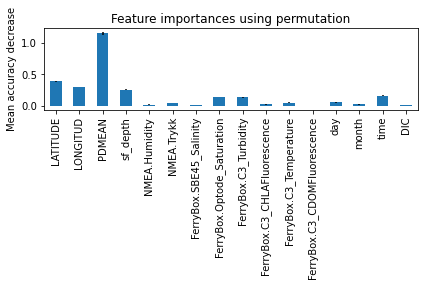

In [21]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Plotting

In [ ]:
# Plot test set 
pred = predict_and_score(X_test, y_test, forest)


In [ ]:
x = range(len(y_test))
plt.scatter(x, y_test, c='g', label='Actual biomass')
plt.scatter(x, pred, c='orange', label='Predicted biomass')
plt.title('Estimated vs predicted biomass')
plt.xlabel('Sample number')
plt.ylabel('Biomass, sA (m\u00b2/nmi\u00b2)') 
plt.legend(loc="lower left")
plt.show()

In [ ]:
df3 = y_test[22500 : 23000]
pred3 = pred[22500 : 23000]
plt.scatter(df3, pred3)
plt.title('Estimated vs predicted biomass')
plt.xlabel('Actual sA (m\u00b2/nmi\u00b2)')
plt.ylabel('Predicted sA (m\u00b2/nmi\u00b2)') 
plt.show()

In [ ]:
def map_plot(depth):
    depth = gpd.GeoDataFrame(
        depth, geometry=gpd.points_from_xy(depth.LATITUDE, depth.LONGITUD))

    depth.reset_index(level=0, inplace=True)
    
    fig = px.scatter_geo(depth,
                    lat=depth.geometry.x,
                    lon=depth.geometry.y,
                    color="TOTAL",
                    size='TOTAL',
                    hover_data=['TOTAL'])
    fig.update_geos(
        center=dict(lon=-30, lat=10),
        lataxis_range=[-30,30], lonaxis_range=[-100, 50]
    )
    fig.update_layout(title = 'Biomass (sA) at 545 meters depth', title_x=0.5, height=500,
                     )
    fig.show()